## Baio AR-1

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm, theano.tensor as tt
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
ts = pd.read_csv('./data/ts14-15.csv')
ts = ts.drop('Unnamed: 0', 1)

# Build team index
teams = ts.home_team.unique()
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index

ts = pd.merge(ts, teams, left_on='home_team', right_on='team', how='left')
ts = ts.rename(columns = {'i': 'i_home'}).drop('team', 1)
ts = pd.merge(ts, teams, left_on='away_team', right_on='team', how='left')
ts = ts.rename(columns = {'i': 'i_away'}).drop('team', 1)

ts = ts.sort_values(by='kick_off', ascending=1)

# Observed goals stats (Eyeball Poisson)
observed_home_goals = ts.home_score.values
observed_away_goals = ts.away_score.values

home_team = ts.i_home.values
away_team = ts.i_away.values

num_teams = len(ts.i_home.drop_duplicates())
num_games = len(home_team)

ts['t'] = 1
ts['t'] = ts['t'].groupby(ts['home_team']).cumsum()

grouped = ts.groupby('t')

observed_home_goals = np.zeros((19,20))
observed_away_goals = np.zeros((19,20))
home_team = np.zeros((19,20))
away_team = np.zeros((19,20))

for t, group in grouped:
    observed_home_goals[t-1] = group.home_score.values
    observed_away_goals[t-1] = group.away_score.values
    home_team[t-1] = group.i_home.values
    away_team[t-1] = group.i_away.values
    
observed_home_goals = observed_home_goals.astype(np.int64)
observed_away_goals = observed_away_goals.astype(np.int64)
home_team = home_team.astype(np.int64)
away_team = away_team.astype(np.int64)

[T, num_teams] = observed_home_goals.shape

In [3]:
with pm.Model() as model:    
    # global model parameters
    home        = pm.Normal('home',      0, .0001)
    tau_att     = pm.Gamma('tau_att',   .1, .1)
    tau_def     = pm.Gamma('tau_def',   .1, .1)
    intercept   = pm.Normal('intercept', 0, .0001)

    # Make auto-regressive
    # [1] Define t0
    atts_ni = [pm.Normal("atts_ni0", mu = 0, tau = tau_att, shape = num_teams)]
    defs_ni = [pm.Normal("defs_ni0", mu = 0, tau = tau_def, shape = num_teams)]
    
    # Identifiability
    atts = [pm.Deterministic('atts0', atts_ni[0] - tt.mean(atts_ni[0]))]
    defs = [pm.Deterministic('defs0', defs_ni[0] - tt.mean(defs_ni[0]))]
    
    home_thetas = [tt.exp(intercept + home + atts[0][home_team[0,:]] + defs[0][away_team[0,:]])]
    away_thetas = [tt.exp(intercept + atts[0][away_team[0,:]] + defs[0][home_team[0,:]])]
    
    home_points = [pm.Poisson('home_points0', mu=home_thetas[0], observed=observed_home_goals[0,:])]
    away_points = [pm.Poisson('away_points0', mu=away_thetas[0], observed=observed_away_goals[0,:])]
    
    # [2] Define t1-T: "stack plates"
    for t in range(1,T):
        atts_ni.append(pm.Normal("atts_ni{0}".format(t), mu = atts[t-1], tau = tau_att, shape = num_teams))
        defs_ni.append(pm.Normal("defs_ni{0}".format(t), mu = defs[t-1], tau = tau_def, shape = num_teams))

        atts.append(pm.Deterministic("atts{0}".format(t), atts_ni[t] - tt.mean(atts_ni[t])))
        defs.append(pm.Deterministic("defs{0}".format(t), defs_ni[t] - tt.mean(defs_ni[t])))
        
        home_thetas.append(tt.exp(intercept + home + atts[t][home_team[t,:]] + defs[t][away_team[t,:]]))
        away_thetas.append(tt.exp(intercept + atts[t][away_team[t,:]] + defs[t][home_team[t,:]]))

        # likelihood of observed data
        home_points.append(pm.Poisson("home_points{0}".format(t), mu=home_thetas[t], observed=observed_home_goals[t,:]))
        away_points.append(pm.Poisson("away_points{0}".format(t), mu=away_thetas[t], observed=observed_away_goals[t,:]))

Applied log-transform to tau_att and added transformed tau_att_log to model.
Applied log-transform to tau_def and added transformed tau_def_log to model.


In [4]:
# Choose starting point based on ADVI fit
with model:
    mu, sds, elbo = pm.variational.advi(n=100000)

Iteration 0 [0%]: ELBO = -4463.3
Iteration 10000 [10%]: ELBO = -1482.08
Iteration 20000 [20%]: ELBO = -1390.78
Iteration 30000 [30%]: ELBO = -1361.36
Iteration 40000 [40%]: ELBO = -1360.03
Iteration 50000 [50%]: ELBO = -1362.3
Iteration 60000 [60%]: ELBO = -1357.92
Iteration 70000 [70%]: ELBO = -1391.24
Iteration 80000 [80%]: ELBO = -1321.49
Iteration 90000 [90%]: ELBO = -1318.42
Finished [100%]: ELBO = -1323.18


In [5]:
# MCMC
with model:
    start = mu
    step = pm.Metropolis()
    trace = pm.sample(15000, step)

 [-----------------100%-----------------] 15000 of 15000 complete in 223.7 sec

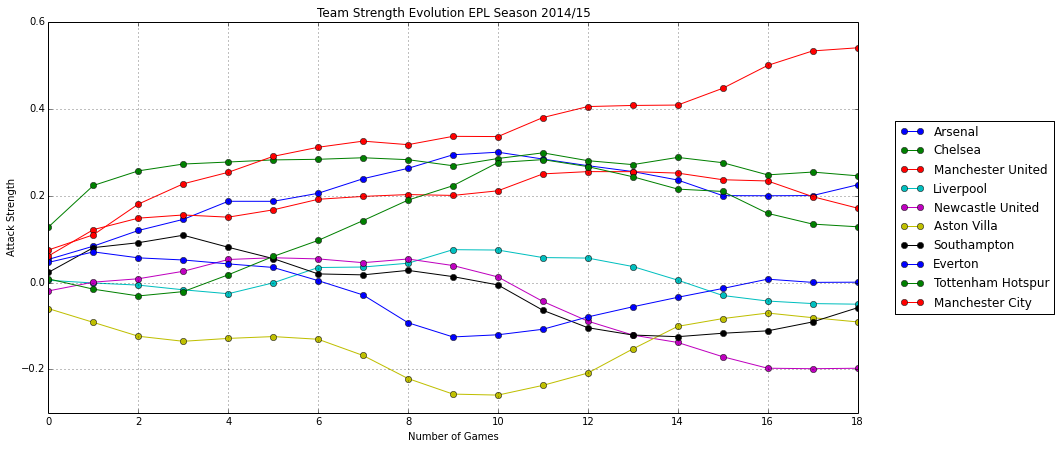

In [6]:
atts = []

for t in range(T):
    tmp = trace['atts{0}'.format(t)]
    tmp = np.swapaxes(tmp,0,1)
    atts.append([n.mean() for n in tmp])
    
atts = np.swapaxes(atts,0,1)
x = range(T)

fig, ax = plt.subplots()
fig.set_size_inches(14.5, 7)

for i in range(10):
    plt.plot(x, atts[i], marker='o', label=teams['team'][i])

plt.title('Team Strength Evolution EPL Season 2014/15')
plt.xlabel('Number of Games')
plt.ylabel('Attack Strength')
plt.legend(bbox_to_anchor=(1.25, 0.5), loc='right', ncol=1)
plt.grid()
plt.show()

array([[<matplotlib.axes.AxesSubplot object at 0x13fdf0b50>,
        <matplotlib.axes.AxesSubplot object at 0x158c7cb10>]], dtype=object)

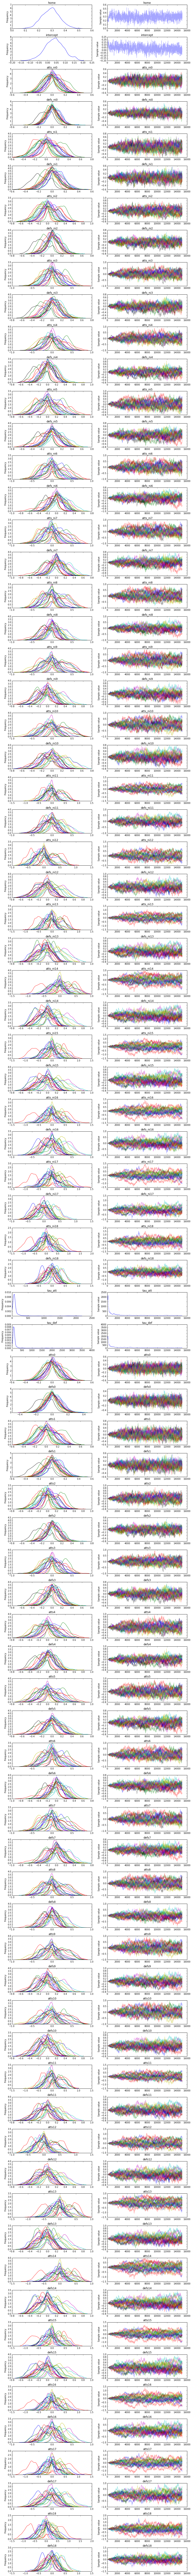

In [7]:
pm.traceplot(trace)